In [32]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
sns.set_theme()

# Pour l'aléatoire
from numpy.random import default_rng, SeedSequence
sq = SeedSequence()
rng = default_rng(sq)

In [33]:
def d1(S0=100, sigma=0.15, r=0.03, K=100, T=1):
    return np.divide(np.log(K/S0) + (r+sigma**2/2)* T, sigma*np.sqrt(T))

In [34]:
def d2(S0=100, sigma=0.15, r=0.03, K=100, T=1):
     return d1(S0, sigma, r, K, T)- sigma*np.sqrt(T)

In [35]:
def bs_call_pricer(S0=100, sigma=0.15, r=0.03, K=100, T=1):
    return S0*norm.cdf(d1(S0, sigma, r, K, T))- K*np.exp(-r*T)*norm.cdf(d2(S0, sigma, r, K, T))


In [36]:
# Black scholes delta
def bs_call_delta(S0=100, sigma=0.15, r=0.03, K=100, T=1):
    return norm.cdf(d1(S0, sigma, r, K, T))

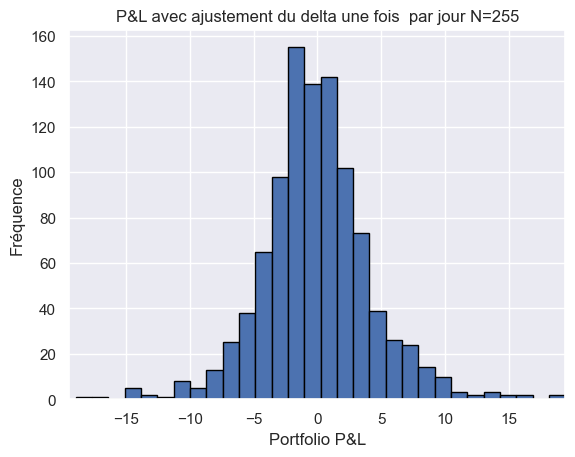

In [45]:
# Donnees
T = 1
N = 255
dt = T / N  # taille du pas de temps
M = 1000
S0 = 100
mu = 0.1
sigma = 0.15
r = 0.03
K = 100

# Initialisation des matrices
S = np.zeros((N+1, M))  # contenir les valeurs du sous-jacent ici on simule mais en pratique c'est les cotations du marché
cash = np.zeros((N+1, M))  # trésorerie du portefeuille
delta = np.zeros((N+1, M))

S[0, :] = S0
price = bs_call_pricer(S[0, :], sigma, r, K, T)  # prix initial de vente de notre option
cash[0, :] = price
delta[0, :] = bs_call_delta(S[0, :], sigma, r, K, T)
cash[0, :] = cash[0, :] - delta[0, :] * S[0, :]  # paiement de la couverture

# Simulation
dw = np.sqrt(dt) * rng.standard_normal((N+1, M))
for j in range(1, N+1):
    S[j, :] = S[j-1, :] * (1 + mu * dt + sigma * dw[j-1, :])
    cash[j, :] = cash[j-1, :] * np.exp(dt * r)
    delta[j, :] = bs_call_delta(S[j, :], sigma, r, K, T - dt * (j-1))
    cash[j, :] = cash[j, :] - (delta[j, :] - delta[j-1, :]) * S[j, :]  # paiement de l'ajustement de la couverture

# Fin et livraison
# Utiliser l'indice N au lieu de N+1
#S[N, :] = S[N-1, :] * (1 + mu * dt + sigma * dw[N-1, :])
cash[N, :] = cash[N-1, :] * np.exp(dt * r)  # on capitalise
cash[N, :] = cash[N, :] + delta[N-1, :] * S[N, :]  # on ajoute le cash obtenu grâce à la vente de la position sur le sous-jacent
pay_off = np.maximum(S[N, :] - K, 0)
livraison = cash[N, :] - pay_off

livraison_norm = (livraison / price)*100
min_val = np.min(livraison_norm)
max_val = np.max(livraison_norm)
range_val = max(abs(min_val), abs(max_val))

# Affichage de l'histogramme
plt.hist(livraison_norm, bins=30, edgecolor='black')

# Ajuster les limites de l'axe des x pour centrer autour de zéro
plt.xlim(left=-range_val, right=range_val)

plt.xlabel('Portfolio P&L')
plt.ylabel('Fréquence')
plt.title('P&L avec ajustement du delta une fois  par jour N=255')
plt.grid(True)
plt.show()



Ici on fait une remise en conformité une fois par jour. La théorie dit que le résultat devrait etre toujours zéro, pour toutes les réalisations. Or on voit que certaines réalisations font des pertes de l'ordre de 10% par rapport au prix de l'option. 
Pourquoi cet écart?

La seule différence avec le modèle de BLack scholes qui est en continu ici est le choix de l'intervalle dt entre deux mises en conformité.

Pour fixer cela tracons l'histogramme équivalent avec des mises en conformité avec le modèle de Black scholes toutes les quinze minutes

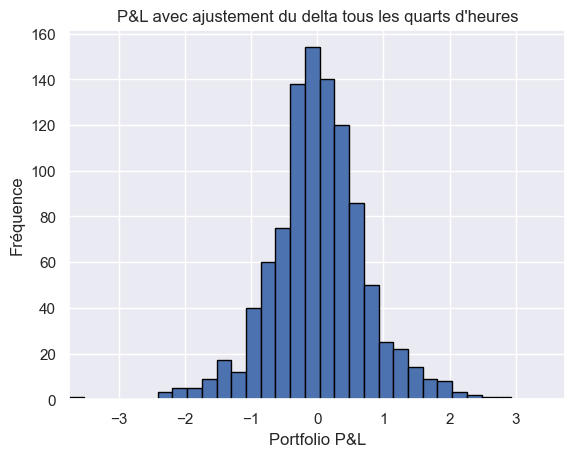

In [46]:
# Donnees
T = 1
N = 255 * 8 * 4  # Nombre de pas de temps jours boursiers
dt = T / N  # taille du pas de temps
M = 1000
S0 = 100
mu = 0.1
sigma = 0.15
r = 0.03
K = 100

S = np.zeros((N+1, M))  # contenir les valeurs du sous-jacent ici on simule mais en pratique c'est les cotations du marché
cash = np.zeros((N+1, M))  # trésorerie du portefeuille
delta = np.zeros((N+1, M))

S[0, :] = S0
price = bs_call_pricer(S[0, :], sigma, r, K, T)  # prix initial de vente de notre option
cash[0, :] = price
delta[0, :] = bs_call_delta(S[0, :], sigma, r, K, T)
cash[0, :] = cash[0, :] - delta[0, :] * S[0, :]  # paiement de la couverture

# Simulation
dw = np.sqrt(dt) * rng.standard_normal((N+1, M))
for j in range(1, N+1):
    S[j, :] = S[j-1, :] * (1 + mu * dt + sigma * dw[j-1, :])
    cash[j, :] = cash[j-1, :] * np.exp(dt * r)
    delta[j, :] = bs_call_delta(S[j, :], sigma, r, K, T - dt * (j-1))
    cash[j, :] = cash[j, :] - (delta[j, :] - delta[j-1, :]) * S[j, :]  # paiement de l'ajustement de la couverture

# Fin et livraison
# Utiliser l'indice N au lieu de N+1
#S[N, :] = S[N-1, :] * (1 + mu * dt + sigma * dw[N-1, :])
cash[N, :] = cash[N-1, :] * np.exp(dt * r)  # on capitalise
cash[N, :] = cash[N, :] + delta[N-1, :] * S[N, :]  # on ajoute le cash obtenu grâce à la vente de la position sur le sous-jacent
pay_off = np.maximum(S[N, :] - K, 0)
livraison = cash[N, :] - pay_off

livraison_norm = (livraison / price)*100
min_val = np.min(livraison_norm)
max_val = np.max(livraison_norm)
range_val = max(abs(min_val), abs(max_val))

# Affichage de l'histogramme
plt.hist(livraison_norm, bins=30, edgecolor='black')

# Ajuster les limites de l'axe des x pour centrer autour de zéro
plt.xlim(left=-range_val, right=range_val)

plt.xlabel('Portfolio P&L')
plt.ylabel('Fréquence')
plt.title("P&L avec ajustement du delta tous les quarts d'heures")
plt.grid(True)
plt.show()



On voit donc bien que la variance ici est bien moindre que dans le cas précédent.


On rappelle qu'on a pas pris en compte les prix des transactions dans les analyses précédentes.
Essayons donc d'investiguer les effets de prise en compte des frais des transactions

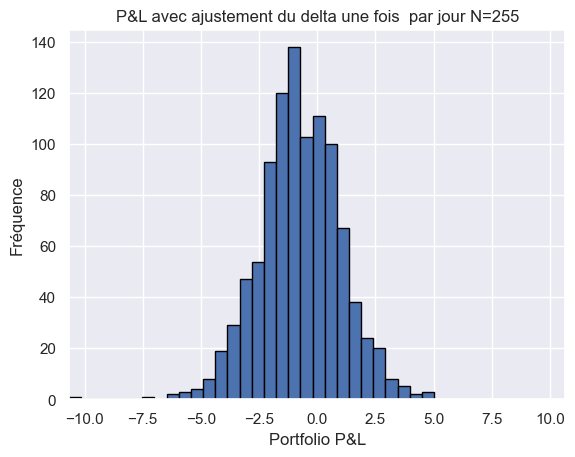

In [47]:
# Robustesse de la couverture d'une option par rapport à l'estimation des paramètres mu et sigma
# Donnees
T = 1
N = 255
dt = T / N  # taille du pas de temps
M = 1000
S0 = 100
mu = 0.6
sigma = 0.15
r = 0.03
K = 100

# Initialisation des matrices
S = np.zeros((N+1, M))  # contenir les valeurs du sous-jacent ici on simule mais en pratique c'est les cotations du marché
cash = np.zeros((N+1, M))  # trésorerie du portefeuille
delta = np.zeros((N+1, M))

S[0, :] = S0
price = bs_call_pricer(S[0, :], sigma, r, K, T)  # prix initial de vente de notre option
cash[0, :] = price
delta[0, :] = bs_call_delta(S[0, :], sigma, r, K, T)
cash[0, :] = cash[0, :] - delta[0, :] * S[0, :]  # paiement de la couverture

# Simulation
dw = np.sqrt(dt) * rng.standard_normal((N+1, M))
for j in range(1, N+1):
    S[j, :] = S[j-1, :] * (1 + mu * dt + sigma * dw[j-1, :])
    cash[j, :] = cash[j-1, :] * np.exp(dt * r)
    delta[j, :] = bs_call_delta(S[j, :], sigma, r, K, T - dt * (j-1))
    cash[j, :] = cash[j, :] - (delta[j, :] - delta[j-1, :]) * S[j, :]  # paiement de l'ajustement de la couverture

# Fin et livraison
# Utiliser l'indice N au lieu de N+1
#S[N, :] = S[N-1, :] * (1 + mu * dt + sigma * dw[N-1, :])
cash[N, :] = cash[N-1, :] * np.exp(dt * r)  # on capitalise
cash[N, :] = cash[N, :] + delta[N-1, :] * S[N, :]  # on ajoute le cash obtenu grâce à la vente de la position sur le sous-jacent
pay_off = np.maximum(S[N, :] - K, 0)
livraison = cash[N, :] - pay_off

livraison_norm = (livraison / price)*100
min_val = np.min(livraison_norm)
max_val = np.max(livraison_norm)
range_val = max(abs(min_val), abs(max_val))

# Affichage de l'histogramme
plt.hist(livraison_norm, bins=30, edgecolor='black')

# Ajuster les limites de l'axe des x pour centrer autour de zéro
plt.xlim(left=-range_val, right=range_val)

plt.xlabel('Portfolio P&L')
plt.ylabel('Fréquence')
plt.title('P&L avec ajustement du delta une fois  par jour N=255')
plt.grid(True)
plt.show()



En vendant une option on peut craindre que si le sous-jacent croit beaucoup ie que son rendement battendu augmentequ'on est d'énormes sommes à rembourser à l'acheteur de l'option s'il décide d'exercer son droit. 

Le résultat ci-dessus montre que ces craintes ne sont pas justifiées. On enregistre des pertes exhorbitantes.

Cela s'explique par le fait que dans le modèle de Black-Scholes le prix et le delta de l'option ne dépendent pas du paramètre mu

In [ ]:
# Paramètre sigma


Pour cela il faut donc consideré que les intervenants sur le marché estiment la volatilité du marché égale à sigma mais qu'en fait le marché évolue avec une voaltilitré sigma_reel qui est peut etre différente de sigma. Ce sigma_reel intervient donc dans la boucle for pour le calcul de S[j,:]

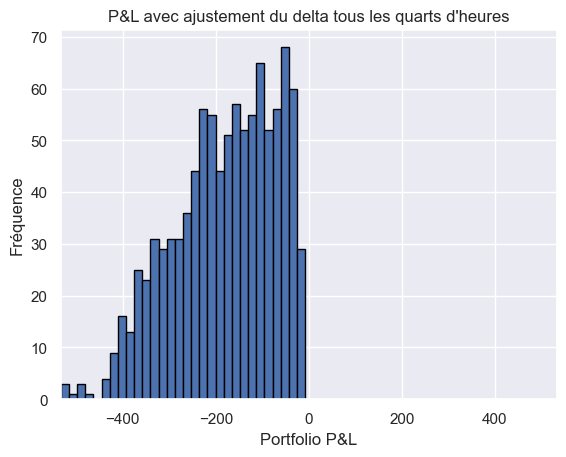

In [48]:
# Donnees
T = 1
N = 255 * 8 * 4  # Nombre de pas de temps jours boursiers
dt = T / N  # taille du pas de temps
M = 1000
S0 = 100
mu = 0.1
sigma = 0.15
sigma_reel= 0.5
r = 0.03
K = 100

S = np.zeros((N+1, M))  # contenir les valeurs du sous-jacent ici on simule mais en pratique c'est les cotations du marché
cash = np.zeros((N+1, M))  # trésorerie du portefeuille
delta = np.zeros((N+1, M))

S[0, :] = S0
price = bs_call_pricer(S[0, :], sigma, r, K, T)  # prix initial de vente de notre option
cash[0, :] = price
delta[0, :] = bs_call_delta(S[0, :], sigma, r, K, T)
cash[0, :] = cash[0, :] - delta[0, :] * S[0, :]  # paiement de la couverture

# Simulation
dw = np.sqrt(dt) * rng.standard_normal((N+1, M))
for j in range(1, N+1):
    S[j, :] = S[j-1, :] * (1 + mu * dt + sigma_reel * dw[j-1, :])
    cash[j, :] = cash[j-1, :] * np.exp(dt * r)
    delta[j, :] = bs_call_delta(S[j, :], sigma, r, K, T - dt * (j-1))
    cash[j, :] = cash[j, :] - (delta[j, :] - delta[j-1, :]) * S[j, :]  # paiement de l'ajustement de la couverture

# Fin et livraison
# Utiliser l'indice N au lieu de N+1
#S[N, :] = S[N-1, :] * (1 + mu * dt + sigma * dw[N-1, :])
cash[N, :] = cash[N-1, :] * np.exp(dt * r)  # on capitalise
cash[N, :] = cash[N, :] + delta[N-1, :] * S[N, :]  # on ajoute le cash obtenu grâce à la vente de la position sur le sous-jacent
pay_off = np.maximum(S[N, :] - K, 0)
livraison = cash[N, :] - pay_off

livraison_norm = (livraison / price)*100
min_val = np.min(livraison_norm)
max_val = np.max(livraison_norm)
range_val = max(abs(min_val), abs(max_val))

# Affichage de l'histogramme
plt.hist(livraison_norm, bins=30, edgecolor='black')

# Ajuster les limites de l'axe des x pour centrer autour de zéro
plt.xlim(left=-range_val, right=range_val)

plt.xlabel('Portfolio P&L')
plt.ylabel('Fréquence')
plt.title("P&L avec ajustement du delta tous les quarts d'heures")
plt.grid(True)
plt.show()



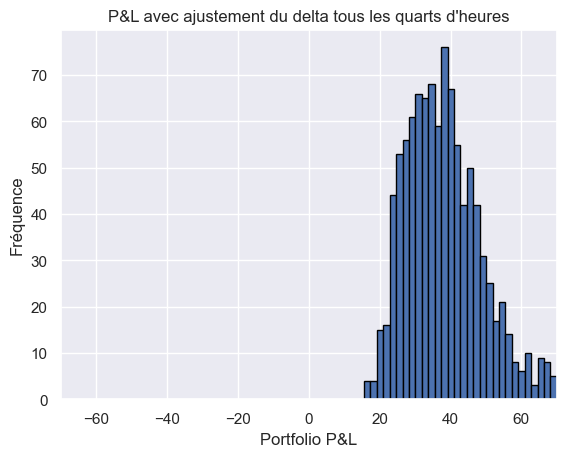

In [49]:
# Donnees
T = 1
N = 255 * 8 * 4  # Nombre de pas de temps jours boursiers
dt = T / N  # taille du pas de temps
M = 1000
S0 = 100
mu = 0.1
sigma = 0.15
sigma_reel= 0.05
r = 0.03
K = 100

S = np.zeros((N+1, M))  # contenir les valeurs du sous-jacent ici on simule mais en pratique c'est les cotations du marché
cash = np.zeros((N+1, M))  # trésorerie du portefeuille
delta = np.zeros((N+1, M))

S[0, :] = S0
price = bs_call_pricer(S[0, :], sigma, r, K, T)  # prix initial de vente de notre option
cash[0, :] = price
delta[0, :] = bs_call_delta(S[0, :], sigma, r, K, T)
cash[0, :] = cash[0, :] - delta[0, :] * S[0, :]  # paiement de la couverture

# Simulation
dw = np.sqrt(dt) * rng.standard_normal((N+1, M))
for j in range(1, N+1):
    S[j, :] = S[j-1, :] * (1 + mu * dt + sigma_reel * dw[j-1, :])
    cash[j, :] = cash[j-1, :] * np.exp(dt * r)
    delta[j, :] = bs_call_delta(S[j, :], sigma, r, K, T - dt * (j-1))
    cash[j, :] = cash[j, :] - (delta[j, :] - delta[j-1, :]) * S[j, :]  # paiement de l'ajustement de la couverture

# Fin et livraison
# Utiliser l'indice N au lieu de N+1
#S[N, :] = S[N-1, :] * (1 + mu * dt + sigma * dw[N-1, :])
cash[N, :] = cash[N-1, :] * np.exp(dt * r)  # on capitalise
cash[N, :] = cash[N, :] + delta[N-1, :] * S[N, :]  # on ajoute le cash obtenu grâce à la vente de la position sur le sous-jacent
pay_off = np.maximum(S[N, :] - K, 0)
livraison = cash[N, :] - pay_off

livraison_norm = (livraison / price)*100
min_val = np.min(livraison_norm)
max_val = np.max(livraison_norm)
range_val = max(abs(min_val), abs(max_val))

# Affichage de l'histogramme
plt.hist(livraison_norm, bins=30, edgecolor='black')

# Ajuster les limites de l'axe des x pour centrer autour de zéro
plt.xlim(left=-range_val, right=range_val)

plt.xlabel('Portfolio P&L')
plt.ylabel('Fréquence')
plt.title("P&L avec ajustement du delta tous les quarts d'heures")
plt.grid(True)
plt.show()



Pour un sigma_reel < sigma, le portefeuille est toujours positif et pour un sigma_reel > sigma, le poretefeuille est toujours négatif.

Le portefeuille agit donc comme un pari sur la volatilité à venir. Si jamais la vol a à venir est plus grande que les attentes alors le détenteur  perdra, sinon il gagneront. 